# ICRA Survey
Thanks for doing our tutorials! We really want to make sure this is valuable for you. 

This [quick 2 minute survey](https://docs.google.com/forms/d/e/1FAIpQLScQiZHguPN7YP18-VhfbqqQw621EswuBIJZj191x70CPrCiKw/viewform?vc=0&c=0&w=1&flr=0) will help us improve them for next year's workshop.

# Tutorial 3: Insufficient Data (2D Range-only)

**API Version: Python NavAbilitySDK.py**

**Keywords:** Range-only, factor graph, under-determined, localization, mapping, SLAM, missing data, insufficient data, robotics, inference, Bayes tree, junction tree

## YouTube Walk Through Video

A walk through of this video has been prepared and can be found at:
[![Tutorial 3 Walk Through](https://img.youtube.com/vi/QczyVI1uQLs/0.jpg)](https://youtu.be/QczyVI1uQLs)

## Application Focus

Many real world state estimation problems (localization or mapping) involve practical situations where too little measurement data can be collected in certain environments.  Various examples exist, for example GPS-denied navigation, or more abstractly named weakly observable (or underdetermined) systems.  We highlighting a few specific examples:
- Indoor **radio ranging navigation** in warehouse or manufacturing applications (signal path **occlusions, or jamming**),
- Outdoor radio ranging **localization or safety** applications such as human safety on a worksite (e.g. loss of signal situations),
- **GPS-denied navigation** due to occlusions, urban canyon, jamming when too few satellite signals are being received,
- **Underwater navigation** robustness for long or short baseline **acoustic** localization (LBL, SBL)
Transfer navigation aides **outdoor-to-indoor** in construction or mining (e.g. GPS to radio beacons),
- **GPS signal verification** in spoofing situations by ignoring and cross-checking “fake” signals,
- And many more.

For this tutorial, we imagine a robot traveling around on a flat surface, in a rectangular trajectory simulating range measurements to WiFi beacons from signal power.

![Tutorial 3 Img](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-3/example-wifi.png)

### Using Factor Graphs

This tutorial will show how non-Gaussian behavior can arise because tha variables are weakly or underconstrained by the available measurement dimensions.  This tutorial is designed such that non-Gaussian posteriors occur throughout the entire problem.

We build a factor graph in stages as the robot moves around the environment through pose/keyframe epochs.  The factor graph will be solved with the [open core Caesar.jl solver](https://github.com/JuliaRobotics/Caesar.jl) at each pose epoch, which produces the posterior marginal beliefs on each of the variables in the system.  After each pose epoch solution, we will look at the marginal belief estimates of all the variables in the system.

To further simplify the tutorial, the "odometry" measurement between consecutive poses  are also taken as range-only (i.e. distance-only) measurements.  These "odometry" factors provide less information than conventional wheel or visual odometry constraints might provide.

### One of Four Mechanims

This tutorial shows [one of four mechanisms](https://juliarobotics.org/Caesar.jl/latest/concepts/why_nongaussian/) that can intoduce non-Gaussian behavior into a factor graph system, see other examples for other mechanisms.  Note that the techniques used in this tutorial can readily be combined with with methods from other tutorials.  For example, the pure Gaussian measurement ranging models used here can be replaced with ambiguous measurements shown in ICRA Tutorial 2.  Or, can be combined with uncertain data association (i,e. multi-hypothesis) measurement models for unknown beacon associations similat to the technique used in ICRA Tutorial 4.  Learn more from our peer-reviewed publications listed here: [`CJLDocs/Literature`](https://juliarobotics.org/Caesar.jl/latest/refs/literature/).

### Signatures Used

`Point2`, `PriorPoint2`, `Point2Point2Range`, `MvNormal`, `Normal`.

## Loading The Data

The ground truth positions for vehicle positions GTp and landmark positions GTl can be loaded into memory directly with these values.  **Note,** we are using variable names
- `l1, l2` as ranging beacons with known locations,
- `l3, l4` as ranging beacons with initially unknown locations,  

These beacon landmarks must be in range before measurements can be made to them.  For the tutorial, we imagine a robot moving from one position to the next in the XY space between the landmarks.  We use ground truth positions to build the simulation, while the SLAM solution has to resolve estimates of the variables as the main exercise of the tutorial.  The robot positions are denoted as
- `x0, x1, ...`.

Ground truth data is as follows:

In [ ]:
# # ONLY IF REQUIRED, Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install navabilitysdk

In [ ]:
import numpy as np

# Our dictionary of vehicle positions
GTp = {}
GTp["x0"] = np.array([0.0, 0])
GTp["x1"] = np.array([50.0, 0])
GTp["x2"] = np.array([100.0, 0])
GTp["x3"] = np.array([100.0, 50.0])
GTp["x4"] = np.array([100.0, 100.0])
GTp["x5"] = np.array([50.0, 100.0])
GTp["x6"] = np.array([0.0, 100.0])
GTp["x7"] = np.array([0.0, 50.0])
GTp["x8"] = np.array([0.0, -50.0])

# Our dictionary of landmark positions
GTl = {}
GTl["l1"] = np.array([10.0, 30])
GTl["l2"] = np.array([30.0, -30])
GTl["l3"] = np.array([80.0, 40])
GTl["l4"] = np.array([120.0, -50])

## Loading the Necessary Packages

Next, lets load the required Python packages.

In [ ]:
from navability.entities import *
from navability.services import *
from uuid import uuid4
import asyncio
from numpy.linalg import norm

## Creating the Factor Graph

We assume the robot is traveling on a XY plane, starting at the origin along X and turning left along Y, then negative X, negative Y back to the origin.    After loading the requried packages, lets start creating the factor graph using variables of type `Point2` (a.k.a. `Postion2`).

In [ ]:
# Start with an empty factor graph
navability_client = NavAbilityHttpsClient()
client = Client("guest@navability.io", "SDKpy_" + str(uuid4())[0:4], "Tutorial3_" + str(uuid4())[0:4])
print(client)

In [ ]:
# Define an initial position x0 for the robot, and three landmarks l1, l2, and l3 to 
# indicate the position of the Wifi routers (beacons) 
variable_ids = ["x0", "l1", "l2", "l3"]

# Add the variables
result_ids = []
for v_id in variable_ids:
    result_ids.append(await addVariable(navability_client, client, v_id, VariableType.Point2))

# Wait for all the variables to be loaded.
await waitForCompletion(navability_client, result_ids)

The initial graph also has prior location information about each of the known beacons/landmarks `:l1` and `:l2`.  Let's go ahead and add those as factors:

In [ ]:
# and put priors on l1 and l1, centered at l1 and l2 respectively with covariance of 1 
result_ids = []
for prior_landmark_id in ["l1", "l2"]:
  prior_distribution = FullNormal(mu=GTl[prior_landmark_id], cov=np.diag([1, 1]))
  result_ids.append(await addFactor(navability_client, client, [prior_landmark_id], PriorPoint2(Z=prior_distribution))) 

# Wait for it to be loaded.
await waitForCompletion(navability_client, result_ids)

The `PriorPoint2` is assumed to be a multivariate normal distribution of covariance `diagm(ones(2))`. Note the API `PriorPoint2(::SamplableBelief)` accepts any of the distribution objects that the Caesar.jl libraries support -- this is discussed further in subsection [Various `SamplableBelief` Distribution types](https://juliarobotics.org/Caesar.jl/latest/concepts/dataassociation/#Various-SamplableBelief-Distribution-Types).

Only four WiFi beacons are in the environment where the robot is moving.  Measurements to the WiFi beacons can only be included with there if the signal is within range.  Two of the beacon locations are known as prior information, while the other two beacons are at an unknown location and their location will be eastimated simultaneously to the robot pose location in the same factor graph system -- making this a simultaneous localization and mapping (SLAM) problem.

## Adding Range Measurements Between Variables

Next we connect the three range measurements from the vehicle location `:l0` to the three beacons, respectively – and consider that the range measurements are completely relative between the vehicle and beacon position estimates:

In [ ]:
result_ids = []
# first range measurement from x0 to l1
rhoZ1 = norm(GTl["l1"]-GTp["x0"])
ppr = Point2Point2Range(Z=Normal(rhoZ1, 2))
result_id = await addFactor(navability_client, client, ["x0", "l1"], ppr)
result_ids.append(result_id)

# second range measurement from x0 to l2
rhoZ2 = norm(GTl["l2"]-GTp["x0"])
ppr = Point2Point2Range(Z=Normal(rhoZ2, 2))
result_id = await addFactor(navability_client, client, ["x0", "l2"], ppr)
result_ids.append(result_id)

# third range measurement from x0 to l3
rhoZ3 = norm(GTl["l3"]-GTp["x0"])
ppr = Point2Point2Range(Z=Normal(rhoZ3, 2))
result_id = await addFactor(navability_client, client, ["x0", "l3"], ppr)
result_ids.append(result_id)

# Wait for it to be loaded.
await waitForCompletion(navability_client, result_ids)

The ranging measurement standard deviation of 2.0 or 3.0 is taken, assuming a Gaussian measurement assumption. Again, any distribution could have been used. The factor graph should look as follows:

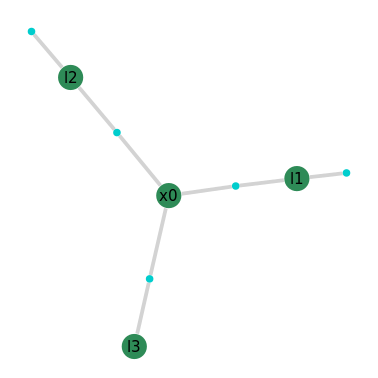

In [1]:
# Make a clickable button link to see you specific session via the NavAbility App.
GraphVizApp(client, variableStartsWith='')

Click the generated button above to see the factor graph via the NavAbility web App, which shows the structure between variables and factors.

The factor graph figure shows the structure between variables and factors.  Note the two priors on `l1` and `l2`, because we have prior information telling us where those beacons are.  The first pose `x0` is only connected via the range measurements, with no prior info about the starting location.  Also no prior info about the location of beacon `l3`.

## Inference and Visualizations

At this point we can call the solver and interpret the first results:

In [ ]:
result_id = await solveSession(navability_client, client)
await waitForCompletion(navability_client, [result_id], maxSeconds=120)
print('running solve...')

A set of tools are provided by the RoMEPlotting packages to show the numerical values contained in the factor graph solution.

First look at the two landmark positions `:l1`, `:l2` at `(10.0,30)`, `(30.0,-30)` respectively.

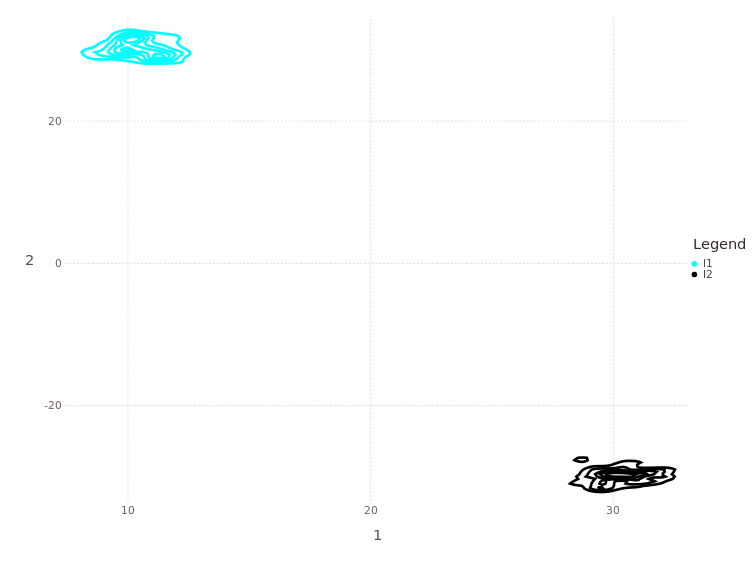

In [2]:
# plotBelief(fg, [:l1;:l2], levels=5, c=["cyan"; "black"])
MapVizApp(client, variableStartsWith='l')

### First Location is Bi-Modal After Solve

Similarly, the belief estimate for the first vehicle position `:x0` is bi-modal, due to the intersection of two range measurements:

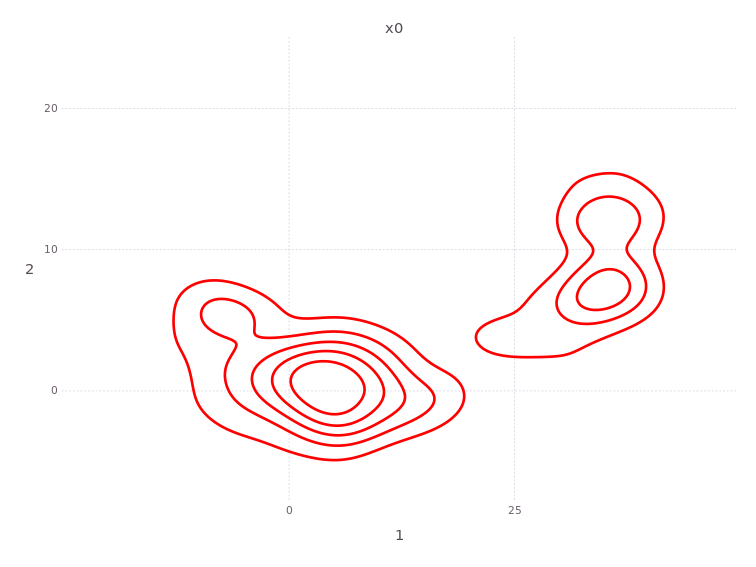

In [2]:
# plotBelief(fg, :x0, levels=5, c=["red"])
MapVizApp(client, variableStartsWith='x')

Note, the first 'robot' positon in this localization and mapping problem is not associated with by a prior factor of any kind.  The initial position could have been anywhere, but the two range measurements to known landmarks limited the uncertainty as shown in the plot above.

### Non-Gaussian Estimate of the Unknown Beacon `:l3`

In contrast to the known beacons `:l1` and `:l2` which have unimodal position estimates in the solution (owing to the prior information/assumptions on each), the belief over the position of unknown landmark `:l3` is simultaneously resolved to a posterior estimate:

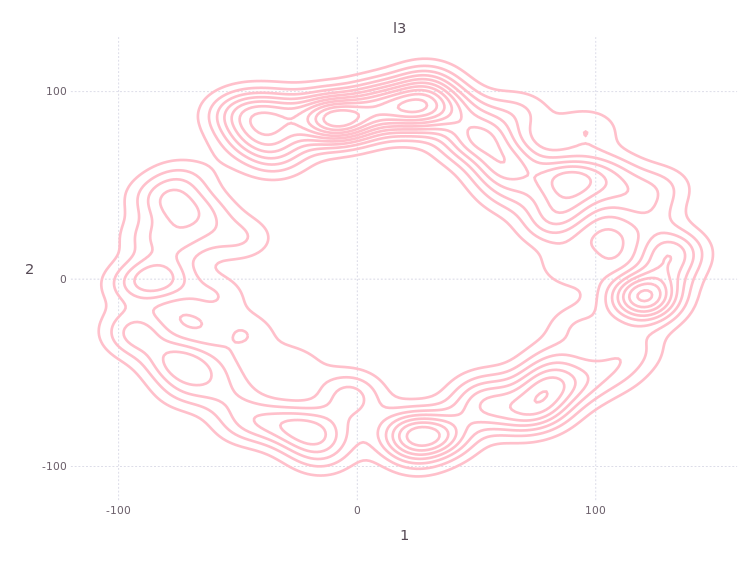

In [3]:
# plotBelief(fg, :l3, levels=10, c=["pink"])
MapVizApp(client, variableStartsWith='l3')

Notice how `:l3`'s location belief (i.e. surveying/mapping) forms a ring around the only available measurement to `:l3` from `:x0`.  A unimodal solution for `:l3` **does not exist**.  In conventional linear modeling, we might say the system is [singular](https://en.wikipedia.org/wiki/Invertible_matrix).

## Gaining and Losing Modes (i.e. Hypotheses)

Next consider the vehicle moving a distance of 50 units–-and by design the direction of travel is not known–-to the next true position. The video above gives away the vehicle position with the cyan line, showing travel in the shape of a lower case 'e'. The following function handles (pseudo odometry) factors as range-only between positions and range-only measurement factors to beacons as the vehice travels.

In [ ]:
# This is a helper function that simulates how the robot moves and measures between ground truth positions.
async def vehicle_drives(client, context, from_lbl, to_lbl, GTp, GTl, measurelimit=150.0):
  currvar = await listVariables(client, context)
  resIds = []
  if not(to_lbl in currvar):
    print("Adding new variable %s" % to_lbl)
    v = await addVariable(client, context, to_lbl, VariableType.Point2)
    resIds.append(v)
    # an odometry distance factor
    rho = norm(GTp[from_lbl] - GTp[to_lbl])
    ppr = Point2Point2Range(Z=Normal(rho, 3.0))
    f = await addFactor(client, context, [from_lbl,to_lbl], ppr)
    resIds.append(f)
  else:
    print("Variable node %s already in the factor graph." % to_lbl)
  
  beacons = GTl.keys()
  for ll in beacons:
    rho = norm(GTl[ll] - GTp[to_lbl])
    # Add measurements to beacons/landmarks if within limit
    if rho < measurelimit:
      if not(ll in currvar):
        print("Adding variable vertex %s, not yet in the session" % ll)
        v = await addVariable(client, context, ll, VariableType.Point2)
        resIds.append(v)
      ppr = Point2Point2Range(Z=Normal(rho, 3.0))
      f = await addFactor(client, context, [to_lbl,ll], ppr)
      resIds.append(f)
  
  # wait to make sure all the new additions are ready
  await waitForCompletion(client, resIds)

After running this function in Julia, a new member definition vehicle_drives_to! can be used line any other function. Julia will handle the just-in-time compiling for the type specific function required and cach the static code for repeat executions.

> **Note**, The exclamation mark at the end of the function is not reserved syntax in Julia, it's just part of the UTF character set.  The exclamation does, however, serve as a Julia community convention to tell the caller that this function will modify the contents of at least one of the variables being passed into it – in this case the factor graph `fg` will be modified!

Now the actual driving event can be added to the factor graph:

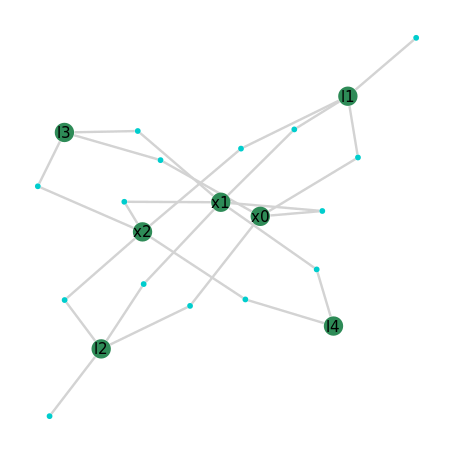

In [5]:
#drive to location :x1, then :x2
await vehicle_drives(navability_client, client, 'x0', 'x1', GTp, GTl)
await vehicle_drives(navability_client, client, 'x1', 'x2', GTp, GTl)

# see the graph
GraphVizApp(client, variableStartsWith='')

**Note**, the distance traveled could be any combination of accrued direction and speeds, however, a straight line Gaussian error model is used to keep the visual presentation of this example as simple as possible.

Lets solve the whole factor graph again.

In [ ]:
result_id = await solveSession(navability_client, client)
await waitForCompletion(navability_client, [result_id], maxSeconds=120)
print('running solve...')

### Multi-Modal (i.e. Multi-Hypothesis) Solution

Now lets look at the robot position marginal beliefs.  We'll use a slightly lower level plotting function, `plotBelief`, to show the posterior beliefs of the tree robot locations:

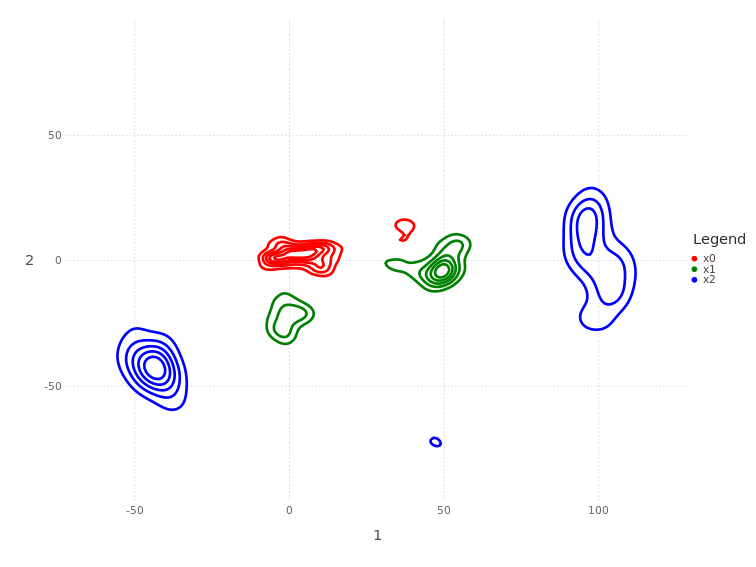

In [6]:
# plotBelief(fg, [:x0; :x1; :x2], levels=5, c=["red","green","blue"])
MapVizApp(client, variableStartsWith='x')

Notice how the robot trajectory has 2+ hypotheses,
- a) starting from `(0,0)` and traversing left to right, and 
- b) starting from `(50,-5)` and traversing left down.

Both are valid solutions!

### Resolving Estimates for New Beacons `:l3` and `:l4`

So far we have measurements to the **initially unknown beacons** as:
- ranges to `:l3` were measured from all three robot positions `[:x0,:x1,:x2]`, and
- ranges to `:l4` were only mearured from two robot positions `[:x1, :x2]`

Can you guess what the posterior belief estimate on new beacons `:l3` or `:l4` are given the available information up this point?  Let's plot and see...

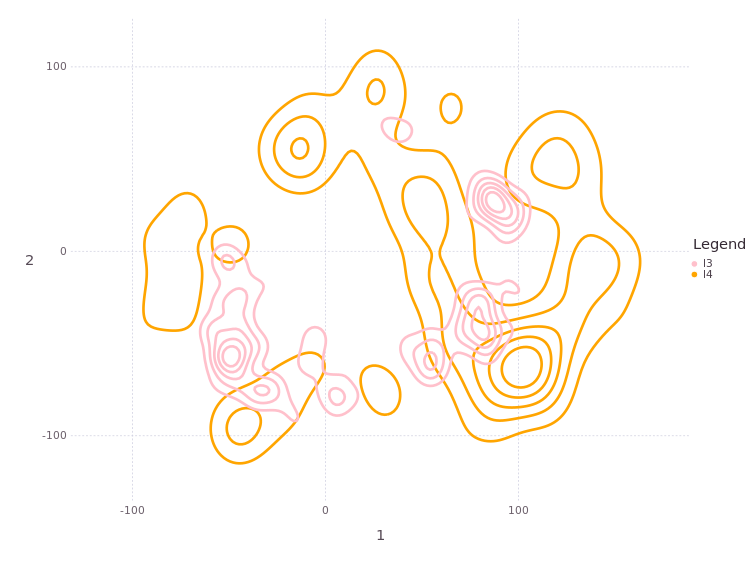

In [7]:
# plotBelief(fg, [:l3;:l4], levels=5, c=["pink"; "orange"])
MapVizApp(client, variableStartsWith='l')

The two "free" beacons/landmarks `:l3,:l4` still have several modes each, implying insufficient data to constrain either to a conventional unimodal belief.

## Robot Moves Two More Positions

The robot drives further to collect more information, keeping in mind that so far that only the two known beacons `:l1` and `:l2` have unimodal posterior belief estimates!  All other variables in the system `[:l3;:l4; :x0;:x1;:x2]` have multi-modal belief

In [ ]:
await vehicle_drives(navability_client, client, 'x2', 'x3', GTp, GTl)
await vehicle_drives(navability_client, client, 'x3', 'x4', GTp, GTl)

result_id = await solveSession(navability_client, client)
await waitForCompletion(navability_client, [result_id], maxSeconds=120)
print('running solve...')

### Estimating the Robot's Latest Position at `:x3`

After the above factor graph solution, lets see what the latest robot position belief estimate looks like: 

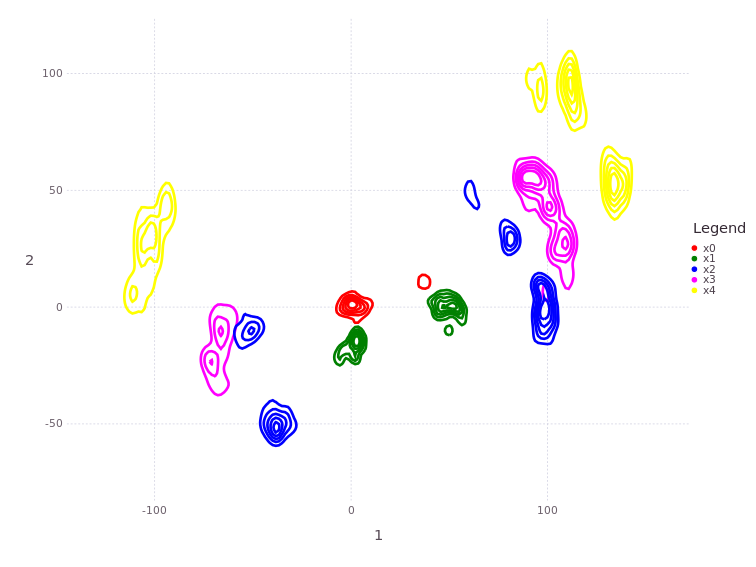

In [8]:
# plotBelief(fg, [:x0;:x1;:x2;:x3;:x4], levels=5) #, c=["red";"green";"blue";"magenta"])
MapVizApp(client, variableStartsWith='x')

Notice how, even though several new range measurements were made, the posterior on `:x3` has an increasing number of modes!  The number of modes may vary from solution to solution, but at least two dominant modes should be visible.

Modes are gained or lost based on a combination of the problem setup and nonparametric variations within each individual solve.  More dominant modes are more consistent, while 'weak' modes may come or go from one solve to the next.  If more compute resources are used, then more and more 'weaker' modes will be recovered.

> Several solver parameters can be modified to control the compute load vs. multimodal tracking efficacy.  Join the [Caesar.jl Slack](https://join.slack.com/t/caesarjl/shared_invite/zt-ucs06bwg-y2tEbddwX1vR18MASnOLsw) conversations, or connect with [NavAbility.io](https://www.navability.io/) to learn more.

The first robot position `[:x0,:x1]` belief estimates didn't change much with the addition new information!  There are still active hypotheses in the trajectory estimates going from `:x0` to `:x1`.  Perhaps the reason for that is because the new landmarks `[:l3; :l4]` are yet to be constrained to a low number of modes, lets see...

### Progress on Locating New Beacons `:l3` and `:l4`

We expect the uncertainty on position estimates for the initially unknown beacons `[:l3;:l4]` to decrease as new measurements are added to the overall problem.  Let's look again at the new posteriors on `:l3` and `:l4`:

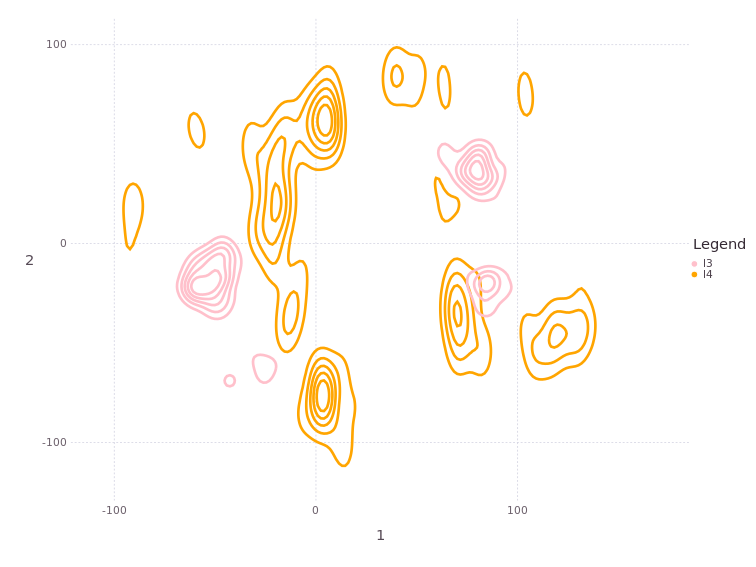

In [9]:
# plotBelief(fg, [:l3;:l4], levels=5, c=["pink"; "orange"])
MapVizApp(client, variableStartsWith='l')

There are still multiple modes on both `:l3` and `:l4`!  We still have way too little information to resolve a unimodal estimate on either the robot positions or the new beacon locations!  The entire system remains underdetermined, i.e. singular!

### Moving to Positions `:x5` and `:x6`

The robot moves further through positions `:x5` and `:x6`, and let's solve again and look at the results:

In [ ]:
await vehicle_drives(navability_client, client, 'x4', 'x5', GTp, GTl)
await vehicle_drives(navability_client, client, 'x5', 'x6', GTp, GTl)

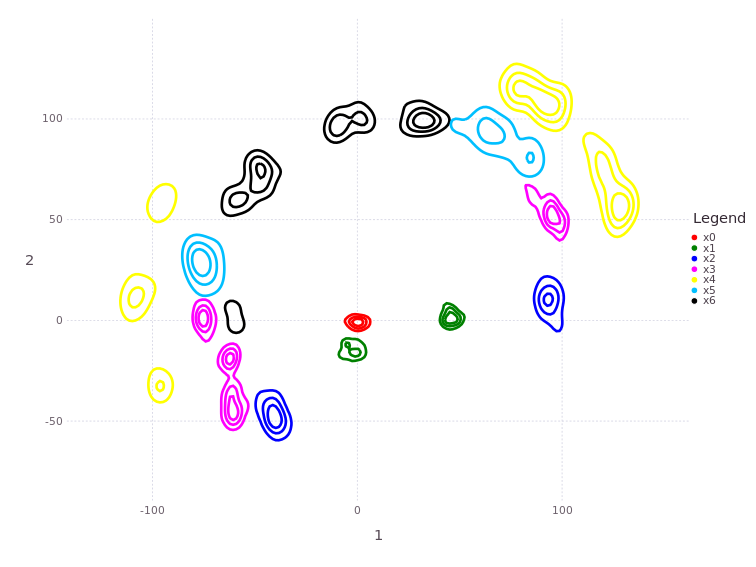

In [10]:
result_id = await solveSession(navability_client, client)
await waitForCompletion(navability_client, [result_id], maxSeconds=120)
print('running solve...')

# plotBelief(fg, [Symbol("x$i") for i=0:6], levels=3)
MapVizApp(client, variableStartsWith='x')

#### Reviewing Landmark Location Estimates Again

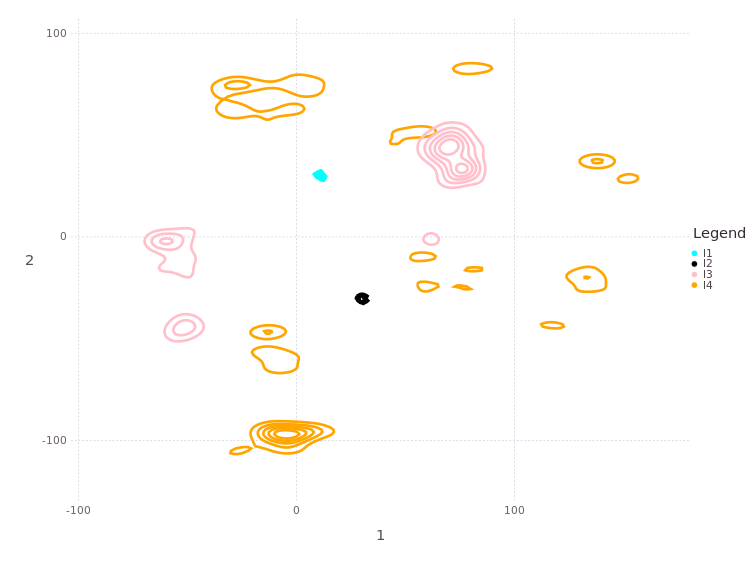

In [11]:
# plotBelief(fg, [:l1;:l2;:l3;:l4], levels=5, c=["cyan";"black";"pink"; "orange"])
MapVizApp(client, variableStartsWith='l')

## Moving to Positions `:x7` and `:x8`

In [ ]:
await vehicle_drives(navability_client, client, 'x6', 'x7', GTp, GTl)
await vehicle_drives(navability_client, client, 'x7', 'x8', GTp, GTl)

In [ ]:
result_id = await solveSession(navability_client, client)
await waitForCompletion(navability_client, [result_id], maxSeconds=120)

print('running solve...')

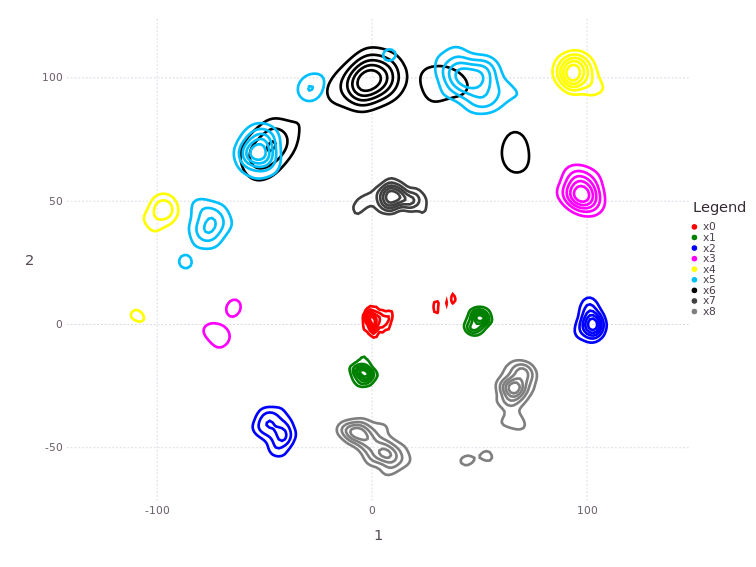

In [12]:
# plotBelief(fg, sortDFG(ls(fg, r"x\d")), levels=5)
MapVizApp(client, variableStartsWith='x')

Next we see a strong return to a single dominant mode in all vehicle position estimates, owing to the increased measurements to beacons/landmarks as well as more unimodal estimates in `:l3, :l4` beacon/landmark positions.

Several location belief estimates exhibit multimodality as the trajectory progresses (not shown), but collapses a stable set of dominant position estimates.  Landmark estimates are also stable at one estimate:

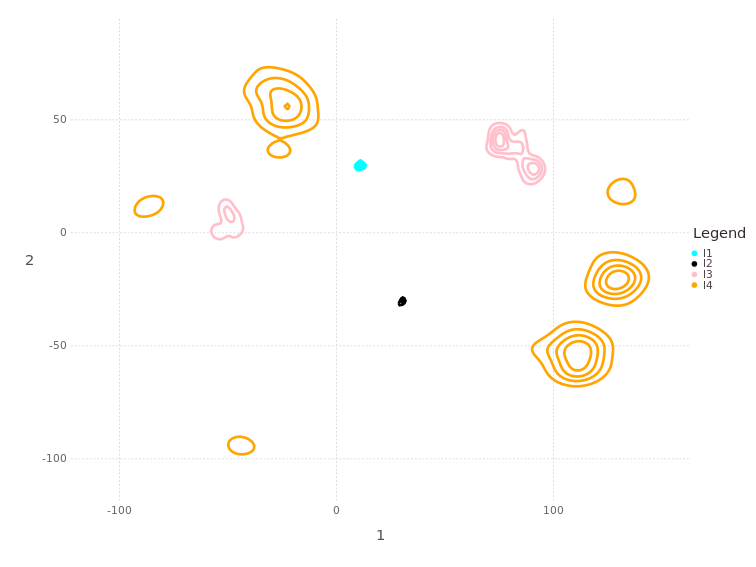

In [13]:
# plotBelief(fg, [:l1;:l2;:l3;:l4], levels=4)
MapVizApp(client, variableStartsWith='l')

Lets also just look at what the factor graph looks like at this point:

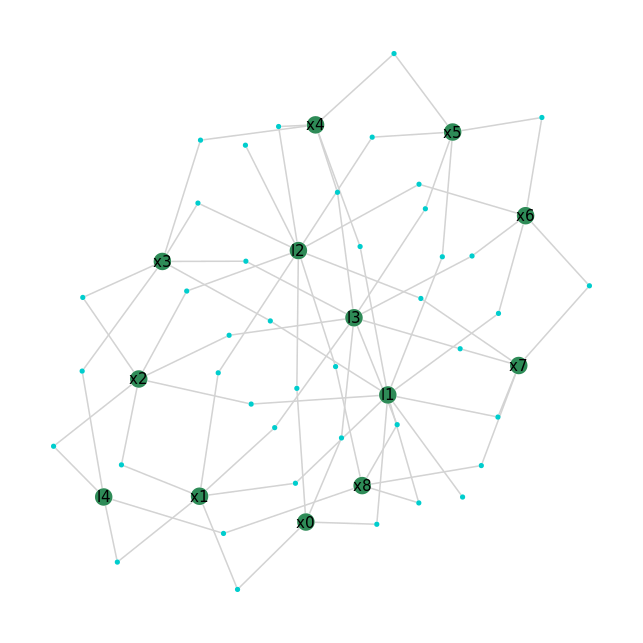

In [14]:
GraphVizApp(client, variableStartsWith='')

## Conclusion

Theoretically, should there be one or more overall trajectory hypotheses in the final result?

## Next Steps

- This Tutorial showed [ONE OF FOUR](https://juliarobotics.org/Caesar.jl/latest/concepts/why_nongaussian/) identified mechanisms how non-Gaussian behavior can enter a localization and mapping system.  See the other tutorials and material for similar discussions on other mechanism by which multi-modal posteriors manifest.
- For a longer version of this example, see [open-source solver documentation here](https://juliarobotics.org/Caesar.jl/latest/examples/basic_slamedonut/).

Visit [www.NavAbility.io](https://www.NavAbility.io) for more about how to use these and other advanced navigation features in your application.